In [16]:
from sklearn.decomposition import PCA
from sklearn.random_projection import SparseRandomProjection
import sklearn, scipy

from minisom import MiniSom

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import datasets
from sklearn.preprocessing import scale

from sklearn.cluster import KMeans

from colour import Color
from graphviz import Digraph

import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

import pandas as pd
import gin
import seaborn as sns

In [17]:
gin.enter_interactive_mode()

In [18]:
df_pivot = pd.read_csv('../../results/pairs_win_rate_player_1_pbt_5adv.csv', index_col=0)

In [19]:
df_pivot_norm = pd.DataFrame(sklearn.preprocessing.normalize(df_pivot))
df_pivot_norm.index = df_pivot.index
df_pivot_norm.columns = df_pivot.columns

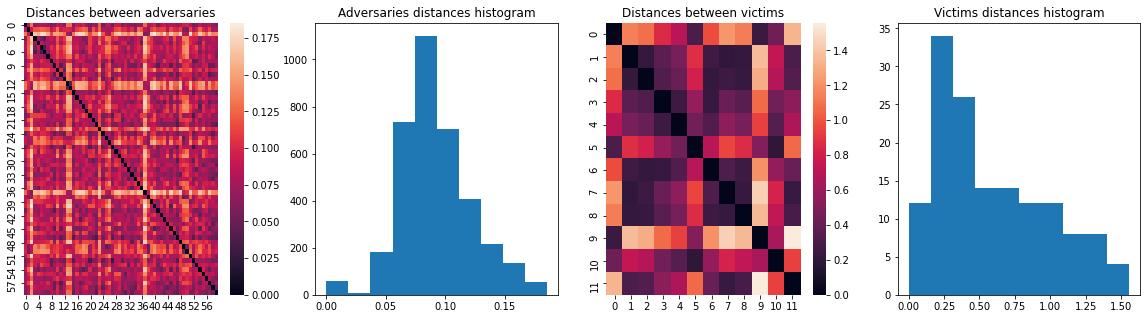

In [20]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.title("Distances between adversaries")
dist_pairs = scipy.spatial.distance.cdist(df_pivot_norm, df_pivot_norm)
sns.heatmap(dist_pairs)

plt.subplot(1, 4, 2)
plt.title("Adversaries distances histogram")
plt.hist(dist_pairs.flatten())

plt.subplot(1, 4, 3)
plt.title("Distances between victims")
dist_pairs = scipy.spatial.distance.cdist(df_pivot_norm.T, df_pivot_norm.T)
sns.heatmap(dist_pairs)

plt.subplot(1, 4, 4)
plt.title("Victims distances histogram")
plt.hist(dist_pairs.flatten())
plt.show()

In [21]:
assert df_pivot.index[0][0] == 'a'
assert df_pivot.columns[0][0] == 'v'

In [22]:
PCA = gin.external_configurable(PCA)
KMeans = gin.external_configurable(KMeans)

In [23]:
@gin.configurable
def cluster_vectors(method, vectors, visual_method=None, names=None, plot=False):
    """Cluster input vectors using a method."""
    m = method()
    out = m.fit_transform(vectors)
    n_clusters = len(m.cluster_centers_)
    clusters = range(n_clusters)
    n_data = len(vectors)
    dist_vec_cluster = scipy.spatial.distance.cdist(vectors, m.cluster_centers_)
    items_in_cluster = {cluster: [i for i in range(n_data) if m.labels_[i] == cluster]
                        for cluster in range(n_clusters)}
#     print(items_in_cluster)
    
    closest_to_center = [np.argmin([dist_vec_cluster[v, c] for v in items_in_cluster[c]]) for c in clusters]
    closest_to_center = [items_in_cluster[c][closest_idx] for closest_idx, c in zip(closest_to_center, clusters)]
#     print(closest_to_center)

    names_aggregate = [' '.join([names[i] for i in items_in_cluster[c]]) for c in clusters]
    
#     print(names_aggregate)
    
    # showing the visualization
    if plot and visual_method is not None:
        assert len(vectors) == len(names)
        vis = visual_method(n_components=2)
        v_pca = vis.fit_transform(vectors)
        plt.figure(figsize=(10, 5))
        plt.title(f"Clustering with {method.__name__}, {n_clusters} clusters, {visual_method.__name__} space")
        plt.scatter(v_pca[:, 0], v_pca[:, 1], c=m.labels_)
        for i in range(n_data):
            plt.text(x=v_pca[i, 0], y=v_pca[i, 1], s=names[i])
            
        c_pca = vis.transform(m.cluster_centers_)
        plt.scatter(c_pca[:, 0], c_pca[:, 1], c=clusters, s=150)
        for c in clusters:
            closest_idx = closest_to_center[c]
            plt.scatter(*v_pca[closest_idx, :], marker='2', c=c, s=150)
        
        plt.show()
    
    return {'labels': m.labels_,
            'clusters': m.cluster_centers_,
            'closest_to_center': closest_to_center,
            'names': names_aggregate}

In [33]:
gin.bind_parameter("KMeans.n_clusters", 7)
gin.bind_parameter("cluster_vectors.method", KMeans)
gin.bind_parameter("cluster_vectors.visual_method", PCA)

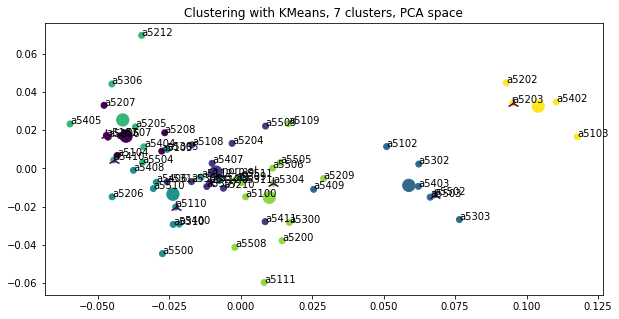

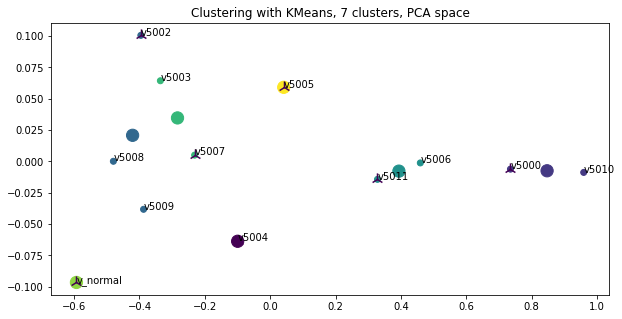

In [34]:
clustered_adversaries = cluster_vectors(vectors=df_pivot_norm, plot=True, names=df_pivot.index)
clustered_victims = cluster_vectors(vectors=df_pivot_norm.T, plot=True, names=df_pivot.columns)

In [35]:
clustered_victims

{'labels': array([1, 2, 4, 0, 6, 3, 4, 2, 2, 1, 3, 5], dtype=int32),
 'clusters': array([[0.27283911, 0.26052205, 0.27431223, 0.2708592 , 0.25632639,
         0.2984379 , 0.28043785, 0.27748803, 0.25351142, 0.2665302 ,
         0.29184764, 0.25679759, 0.26407081, 0.29867339, 0.27989269,
         0.25318833, 0.23159383, 0.27069473, 0.26459268, 0.24391622,
         0.27328279, 0.30527637, 0.26880167, 0.26009814, 0.28934514,
         0.26864661, 0.3048593 , 0.25357086, 0.227005  , 0.22279136,
         0.28749002, 0.28466341, 0.250805  , 0.2918426 , 0.26954406,
         0.2563377 , 0.2782845 , 0.27031858, 0.28002234, 0.22444937,
         0.23125119, 0.25304648, 0.26985594, 0.27693472, 0.30284413,
         0.24736695, 0.28740229, 0.27055166, 0.28980547, 0.28388611,
         0.2723461 , 0.24696355, 0.26422764, 0.25111387, 0.26141979,
         0.28324159, 0.28561985, 0.27032388, 0.2870474 , 0.27179569],
        [0.39478992, 0.36100912, 0.33603248, 0.4000382 , 0.39466127,
         0.40141999, 

In [36]:
df_clustered = df_pivot.iloc[clustered_adversaries['closest_to_center'], clustered_victims['closest_to_center']].copy()
df_clustered.index = clustered_adversaries['names']
df_clustered.columns = clustered_victims['names']
df_clustered

,v5004,v5000 v5010,v5002 v5008 v5009,v5006 v5011,v5003 v5007,v_normal,v5005
a5104 a5105 a5106 a5107 a5207 a5208 a5507,67.0,90.0,57.0,84.0,61.0,40.0,69.0
a5108 a5204 a5210 a5307 a5308 a5312 a5407 a5411 a5412 a5509 a_normal,65.0,93.0,52.0,77.0,57.0,49.0,68.0
a5102 a5302 a5303 a5403 a5409 a5502 a5503,78.0,100.0,65.0,87.0,70.0,63.0,77.0
a5110 a5112 a5206 a5211 a5305 a5310 a5400 a5406 a5408 a5500 a5510 a5511,64.0,95.0,50.0,71.0,61.0,50.0,69.0
a5205 a5212 a5306 a5404 a5405 a5410 a5504,59.0,97.0,51.0,76.0,57.0,44.0,72.0
a5100 a5109 a5111 a5200 a5209 a5300 a5304 a5309 a5311 a5505 a5506 a5508,61.0,91.0,56.0,76.0,59.0,56.0,65.0
a5103 a5202 a5203 a5402,77.0,91.0,70.0,81.0,68.0,63.0,84.0


In [47]:
df_clustered = df_pivot

In [48]:
cols = list(Color("white").range_to("blue", 20))

In [49]:
from IPython.display import HTML as html_print

def cstr(color='black'):
    return f"""<svg width="20" height="20"><rect width="20" height="20" style="fill:{color};stroke-width:3;stroke:rgb(0,0,0)" /></svg>""".format(color)

colors = cols
html_print(''.join([cstr(c) for c in colors]) + '<span></span>')

In [50]:
def plot_df_as_graph(df):
    n_colors = 100
    adv_win_color = list(Color("white").range_to("red", n_colors))
    vct_win_color = list(Color("white").range_to("blue", n_colors))

    def closest(frac, colors):
        """Closest color to a fraction."""
        closest_idx = np.argmin(np.abs(np.linspace(0, 1, n_colors) - frac))
        return colors[closest_idx].get_hex_l()

    edges_lst = []
    edge_strength = []
    edge_color = []

    # eng="circo"
    # eng="neato"
    eng=None
    ps = Digraph(name='Win model', engine=eng, graph_attr=dict(nodesep="0.1"), node_attr={"nodesep": ".1", "overlap":"true"})
    # node_attr={'shape': 'plaintext'})

    for f in df.columns:
        ps.node(f, color='blue')
    for f in df.index:
        ps.node(f, color='red')

    # adding edges
    edges = 0

    for p2 in df.columns:
        for p1 in df.index:
            val = df.loc[p1, p2]

            v1v2 = [p1, p2]

            maxwidth = 5
            strength = abs(val - 50) / 50
            width = maxwidth * strength


            # val > 50 means that player 1 (adversary) wins
            # arrow goes FROM the winning player
            if val > 50:
                label = None#str(round(val))
                color = closest(strength, adv_win_color)
                ps.edge(*v1v2, label=label, penwidth=str(width), color=color, len=".1")
                edges_lst.append(v1v2)
                edge_strength.append(strength)
                edge_color.append(color)
                edges += 1
            else:
                label = None#str(round(val))
                color = closest(strength, vct_win_color)
                ps.edge(*v1v2[::-1], label=label, penwidth=str(width), color=color, len=".1")
                edge_strength.append(strength)
                edge_color.append(color)
                edges_lst.append(v1v2[::-1])
                edges += 1

    max_edges = len(df.index) * len(df.columns)
    percent = int(100 - 100. * edges / max_edges)
    print("Number of edges: %d out of %d, sparsity %.2f%%" % \
          (edges, max_edges, percent))

    # f_out = f"CausalModel"
    # ps.render(filename=f_out, format='png')
    
    allnodes = [v for e in edges_lst for v in e]

    # Create Directed Graph
    G=nx.DiGraph()

    # Add a list of nodes:
    G.add_nodes_from(allnodes)

    # Add a list of edges:
    G.add_edges_from(edges_lst)


    return ps, G

Number of edges: 720 out of 720, sparsity 0.00%


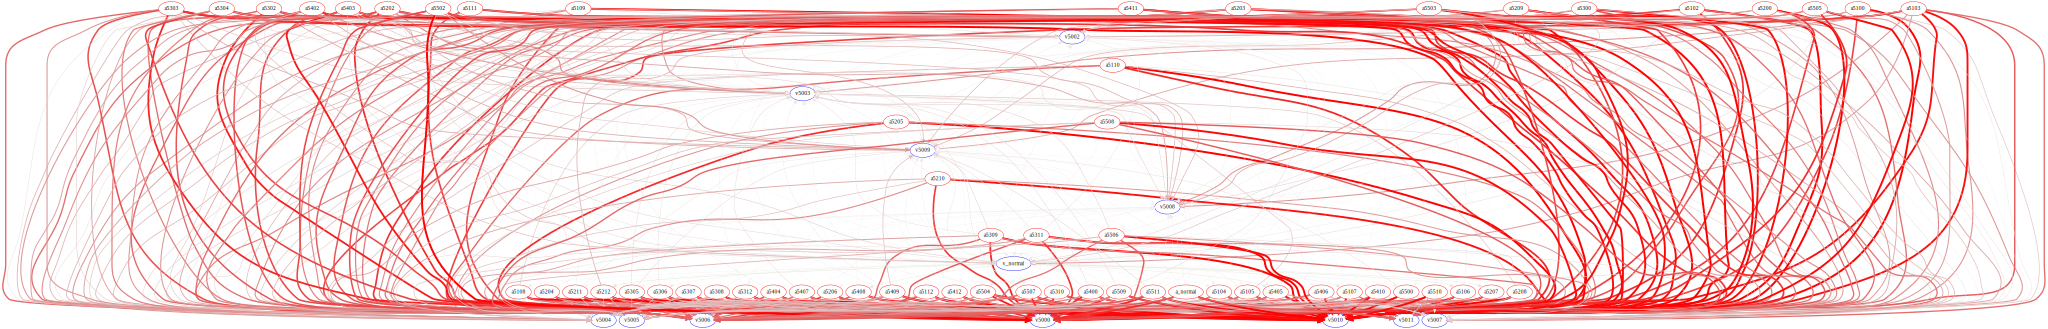

In [51]:
ps, G = plot_df_as_graph(df_clustered)
ps

In [52]:
def strength_for_cycle(cycle):
    strengths = []
#     cycle = cycle + [cycle[0]]
    for i in range(len(cycle) - 1):
        v1, v2 = cycle[i:i+2]
        e_idx = edges_lst.index([v1, v2])
        strength = edge_strength[e_idx]
        strengths.append(strength)
    return strengths

cycles = list(nx.simple_cycles(G))
cycles = [cycle + [cycle[0]] for cycle in cycles]
    
#Return a list of cycles described as a list o nodes
strengths = [strength_for_cycle(cycle) for cycle in cycles]
min_strength = [min(x) for x in strengths]

data = []
for idx in np.argsort(min_strength)[::-1]:
    data.append(dict(cycle=cycles[idx], edge_strength=strengths[idx], min_stength_percent=min_strength[idx] * 100))
pd.DataFrame(data)

NameError: name 'edges_lst' is not defined